In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import  make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython import display

import copy
import random
import time

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Это игрушечно -исследовательское задание
Перед Вами задача бинарной классификации. Как модель мы будем использывать двуслойный перцептрон.
Изучите, как отрабатывают различные оптимизаторы на этой задаче. Обязательно попробовать  Adam, RMSProp, SGD, L-BFGS. Другие тоже можно

Сделать выводы по полученным результатам.

In [2]:
#  Делаем рандомную задачу бинарной классификации. По умолчанию make_classification порождает объект с 20 признаками. 
# Это значение можно варьировать. И его надо подавать как input_size в моддель
X, Y = make_classification(n_samples=10000)

# Делим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=42)

# перегоняем все в торч
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [3]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([8000, 20]),
 torch.Size([2000, 20]),
 torch.Size([8000]),
 torch.Size([2000]))

In [4]:
# Cтроим простой перцептрончик: Один линейный слой потом Релу (что это такое, кстати?=)), еще линейный слой и сигмоиду, которая будет выдавать вероятности классов
# hidden size можно варьировать. input_size - кол-во признаков в объекте

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size

        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.linear1(x)
        relu = self.relu(hidden)
        output = self.linear2(relu)
        output = self.sigmoid(output)
        return output

In [5]:
# Критерий/ функция потерь
criterion = torch.nn.BCELoss()

model = MLP(20, 10)
 # Оптимизаторы. Можете потыкать все из торча. обязательно Adam, RMSProp, SGD, L-BFGS
optimizer = torch.optim.Adam(model.parameters())

In [6]:
def evaluate_optimizer(optimizer, model, n_epochs=200, batch_size=8):
    sns.set()

    epoch_array = []
    epoch_test_array = []
    for epoch in range(n_epochs):

        # Тут игрушечный пример как делить на батчи
        permutation = torch.randperm(x_train.size()[0])
        loss_array = []

        model.train()
        for i in range(0,x_train.size()[0], batch_size):
        
            def closure():
                #  your code here 
                optimizer.zero_grad()

                # Бьем на батчи. В таком мигрушечном примере это не обязательно, но мы будем делать все по феншую
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = x_train[indices], y_train[indices]

                # Считаем лосс и добавляем его значение в массив
                outputs = model.forward(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)

                loss_array.append(loss.item())
                loss.backward()
                
                return loss


            #  your code here 
            optimizer.step(closure=closure)


        # Будем проверять как отрабатывает модель на тестовом датасете (ЗАЧЕМ?)
        # ТАк еж разбиваем на батчи, считаем лосс, но веса модели не обновляем
        test_permutation = torch.randperm(x_test.size()[0])
        loss_test_array = []
        model.eval()
        with torch.no_grad():
            for i in range(0,x_test.size()[0], batch_size):

                indices = test_permutation[i:i+batch_size]
                batch_x, batch_y = x_test[indices], y_test[indices]
                outputs = model.forward(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)
                loss_test_array.append(loss.item())

            # усредняем лосс на обучении и тесте по эпохе  и выводим график
            epoch_array.append(np.mean(loss_array))
            epoch_test_array.append(np.mean(loss_test_array))

#         display.clear_output(wait=True)
#         plt.figure(figsize =(12, 7))
#         plt.plot(epoch_array, label ="TRAIN")
#         plt.plot(epoch_test_array, label ="TEST")
#         plt.legend(loc="best", fontsize=20)
#         plt.show()

    return epoch_array, epoch_test_array

Evaluating Adam
Evaluating Adamax
Evaluating RMSprop
Evaluating SGD
Evaluating L-BFGS


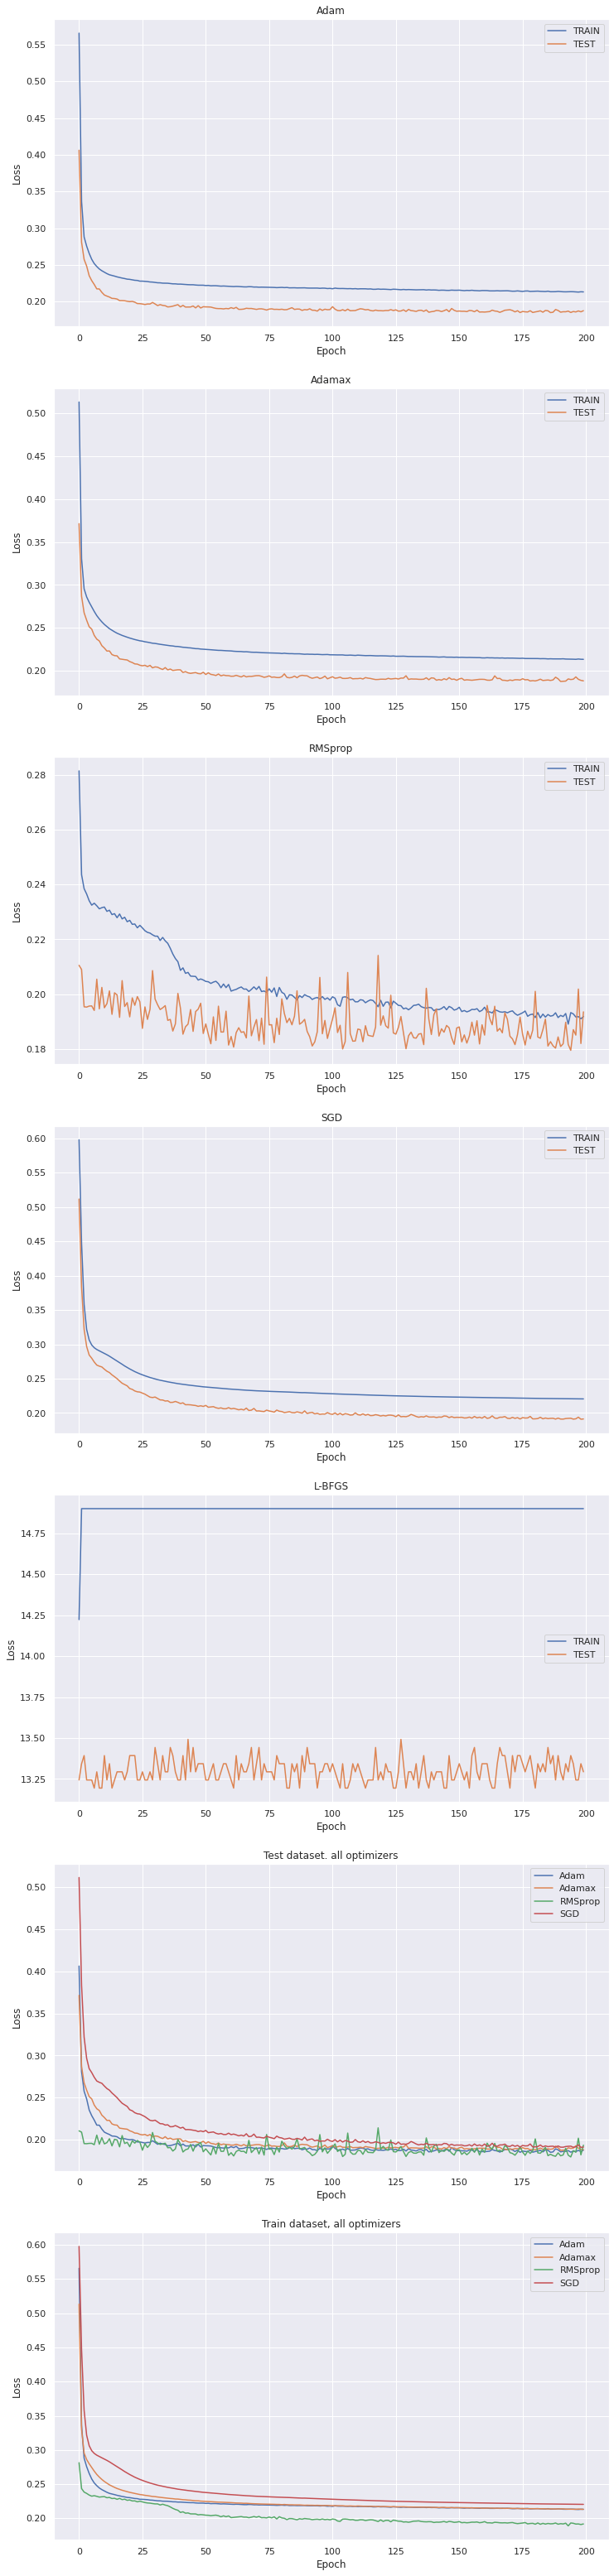

In [7]:
sns.set()

models = [
    MLP(20, 10),
    MLP(20, 10),
    MLP(20, 10),
    MLP(20, 10),
    MLP(20, 10),
]

optimizers = [
    torch.optim.Adam(models[0].parameters()),
    torch.optim.Adamax(models[1].parameters()),
    torch.optim.RMSprop(models[2].parameters()),
    torch.optim.SGD(models[3].parameters(), lr=1e-2),
    torch.optim.LBFGS(models[4].parameters()),
    
]

names = [
    'Adam',
    'Adamax',
    'RMSprop',
    'SGD',
    'L-BFGS'
]

n_opts = len(optimizers)

fig, axs = plt.subplots(nrows=n_opts + 2, ncols=1, figsize=(12, 8 * (n_opts + 2)))

for ax, model, optimizer, name in zip(axs, models, optimizers, names):
    print("Evaluating", name)
    train_loss, test_loss = evaluate_optimizer(optimizer, model, batch_size=32)
    ax.plot(train_loss, label="TRAIN")
    ax.plot(test_loss, label="TEST")
    ax.set_title(name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
                        
    if name != 'L-BFGS':
        axs[-1].plot(train_loss, label=name)
        axs[-2].plot(test_loss, label=name)

axs[-1].set_xlabel("Epoch")
axs[-1].set_ylabel("Loss")
axs[-2].set_xlabel("Epoch")
axs[-2].set_ylabel("Loss")                        
axs[-1].legend()
axs[-2].legend()
axs[-1].set_title('Train dataset, all optimizers')
axs[-2].set_title('Test dataset. all optimizers')
plt.show()

ОПИШИТЕ ПОЛУЧЕНННЫЕ РЕЗУЛЬТАТЫ

Сошлись все оптимизаторы, кроме L-BFGS (причину мы обсудим позднее). Все они сходятся к близким значениям, лучше всего себя показали Adam и RMSprop, за ними идет Adamax, и замыкает рейтинг SGD (нужно сказать, что изначально SGD сходился медленнее, и я потратил значительное время на подбор параметров для него). 

AFAIK, L-BFGS не сошелся, так как он не предназначен для обучения батчами. Давайте дадим ему шанс обучится на всей выборке:

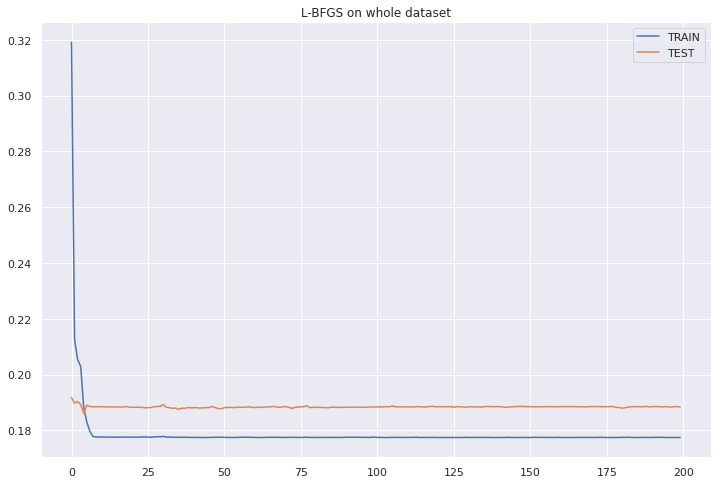

In [8]:
model = MLP(20, 10)
optimizer = torch.optim.LBFGS(model.parameters())
lbfgs_train, lbfgs_test = evaluate_optimizer(optimizer, model, batch_size=8000)

plt.figure(figsize=(12, 8))
plt.plot(lbfgs_train, label="TRAIN")
plt.plot(lbfgs_test, label="TEST")
plt.legend()
plt.title("L-BFGS on whole dataset")
plt.show()

Как мы видим, он сошелся примерно туда же, куда до этого сходились другие оптимизаторы (и значения loss даже меньше, чем у остальных оптимизаторов), притом **крайне** быстро. Great Success! Насколько я понимаю, именно с неспособностью обучаться на батчах связана непопулярность L-BFGS в обучении нейросетей -- несмотря на быструю сходимость, ему необходимо работать со всем датасетом сразу, да еще и сам алгоритм потребляет много памяти, поэтому на больших датасетах его использовать не получится. При этом другие оптимизаторы позволяют добиться сходных результатов с меньшим потреблением и batch-оптимизацией.

# Спасибо за внимание!

## Забавный факт: у волков очень большие лапы
![big paw](big_paw.jpg)
![paws](paws.jpg)

Тайное знание: если вам когда-нибудь будет скучно, и захочется просто посмотреть на волков, если прекрасные [трансляции вебкамер](https://nywolf.org/meet-our-wolves/webcams/) от Wolf Conservation Center в Нью-Йорке (два волка на первой фотографии -- это животные-амбассадоры оттуда).